In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import keras

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, multiply, Softmax,GlobalAveragePooling2D
from keras.models import Model,load_model

import keras.backend as K
from keras import optimizers
from keras.optimizers import Adam

from keras import losses
from os import listdir
from os.path import isfile, join
print("TF version is:   ",tf.__version__)

('TF version is:   ', '1.11.0')


In [1]:
file = open('data/fashionAI_attributes_train1/Annotations/label.csv','r')

paths = []
category = []
label = []
for line in file:
    #print(line)
    #print(line.split(','))
    t = line.split(',')
    paths.append('data/fashionAI_attributes_train1/'+t[0])
    category.append(t[1])
    label.append(t[2][:-1])

categories = list(set(category))
assert len(categories)==8 , "categories not 8"
print("there are 8 categories:", categories)

arr = np.arange(len(paths))
partition = arr
np.random.shuffle(partition)
def label_to_array(llabel):
    return np.array([1 if i=='y' else 0 for i in llabel])

def get_img(index):
    img_path = paths[index]
    img = image.load_img(img_path, target_size=(224,224))
    x_ = image.img_to_array(img)
    x_ = np.expand_dims(x_, axis=0)
    x_ = preprocess_input(x_)    # gives an array in shape of (1,224,224,3)
    label_ = label_to_array(label[index])
    cat_ = categories.index(category[index])
        
    X_cat = np.zeros((80))
    X_cat[cat_*10:cat_*10+10] = np.ones(10)
    
    return x_, label_, cat_, X_cat


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,  batch_size=16, dim=(224,224), n_channels=3,
                 n_classes=80, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        #X_img = np.empty((self.batch_size, *self.dim, self.n_channels))
        X_img = np.empty((self.batch_size,224,224,3))
        y_label = np.zeros((self.batch_size, self.n_classes), dtype=int)
        X_cat = np.zeros((self.batch_size, self.n_classes))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            #print(get_img(ID))
            img_,y_,cat_,cat__ =  get_img(ID)
            X_img[i,]=img_
            y_label[i,y_.argmax()+10*cat_]=1

            X_cat[i,] = cat__
            #X_cat[i,cat_*10:cat_*10+10] = np.ones(10)

        return [X_img,X_cat], y_label #keras.utils.to_categorical(y, num_classes=self.n_classes)

Using TensorFlow backend.


('TF version is:   ', '1.11.0')
('there are 8 categories:', ['lapel_design_labels', 'collar_design_labels', 'skirt_length_labels', 'sleeve_length_labels', 'pant_length_labels', 'neck_design_labels', 'coat_length_labels', 'neckline_design_labels'])


In [2]:
device = '/device:CPU:0'
cfg_base_model = 'incepV3'

In [3]:
with tf.device(device):
  if cfg_base_model=='VGG16':
    vgg_head = VGG16(weights='imagenet',include_top=False)
    vgg_head.name = 'vgg16_head'
    
    img_input = Input(shape=(224,224,3),name = 'image_input')
    cat_input = Input(shape=(80,),name = 'cat_input')

    output_vgg16_conv = vgg_head(img_input)
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(80, activation='softmax', name='shit')(x)
    
    x = multiply(([x, cat_input]))
    x = Softmax(80)(x)
    my_model = Model(inputs=[img_input, cat_input], output=x)
    
  if cfg_base_model=='incepV3':
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)
    base_model.name = 'InceptionV3_head'
    
    img_input = Input(shape=(224,224,3),name = 'image_input')
    cat_input = Input(shape=(80,),name = 'cat_input')

    # add a global spatial average pooling layer
    x = base_model(img_input)
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    x = Dense(80, activation='softmax')(x)
    predictions = multiply(([x, cat_input]))

    # this is the model we will train
    my_model = Model(inputs=[img_input, cat_input], outputs=predictions)

In [4]:
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
InceptionV3_head (Model)        multiple             21802784    image_input[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           InceptionV3_head[1][0]           
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2098176     global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
dense_2 (D

In [99]:
file = open('data/fashionAI_attributes_train2/Annotations/label.csv','r')

paths = []
category = []
label = []
for line in file:
    #print(line)
    #print(line.split(','))
    t = line.split(',')
    paths.append('data/fashionAI_attributes_train2/'+t[0])
    category.append(t[1])
    label.append(t[2][:-1])

categories = list(set(category))
assert len(categories)==8 , "categories not 8"
print("there are 8 categories:", categories)

arr = np.arange(len(paths))
partition = arr
np.random.shuffle(partition)
def label_to_array(llabel):
    return np.array([1 if i=='y' else 0 for i in llabel])

def get_img(index):
    img_path = paths[index]
    img = image.load_img(img_path, target_size=(224,224))
    x_ = image.img_to_array(img)
    x_ = np.expand_dims(x_, axis=0)
    x_ = preprocess_input(x_)    # gives an array in shape of (1,224,224,3)
    label_ = label_to_array(label[index])
    cat_ = categories.index(category[index])
        
    X_cat = np.zeros((80))
    X_cat[cat_*10:cat_*10+10] = np.ones(10)
    
    return x_, label_, cat_, X_cat

('there are 8 categories:', ['lapel_design_labels', 'collar_design_labels', 'skirt_length_labels', 'sleeve_length_labels', 'pant_length_labels', 'neck_design_labels', 'coat_length_labels', 'neckline_design_labels'])


In [101]:
get_img(0)[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
def mean_pred(y_true, y_pred):
    return K.abs(y_true-y_pred)

In [6]:
with tf.device(device):
    model = load_model('adam-weights-improvement-11-0.75.hdf5', custom_objects={'mean_pred': mean_pred})

In [49]:
path_test='data/fashionAI_attributes_train1/Images/coat_length_labels/00075db6ca24b04651e6171e1b70309c.jpg'

In [80]:
collar_design_path = 'data/fashionAI_attributes_train2/Images/collar_design_labels'
im_names = [join(collar_design_path, f) for f in listdir(collar_design_path) if isfile(join(collar_design_path, f))]

In [93]:
path_test=im_names[1]

In [96]:
path_test

'data/fashionAI_attributes_train2/Images/collar_design_labels/0015cc25fa79d18866fe381eb2006081.jpg'

In [94]:
x_test = get_img_test(path_test)
cat_ = categories.index('collar_design_labels')

X_cat = np.zeros((80))
X_cat[cat_*10:cat_*10+10] = np.ones(10)

X_cat = X_cat.reshape(1,80)

In [95]:
im = Image.open(path_test)

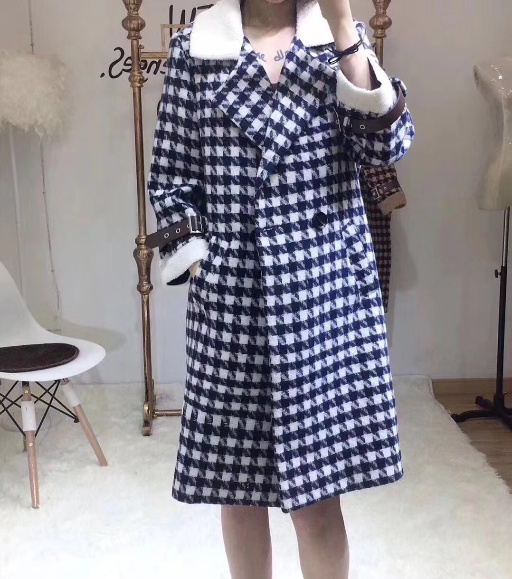

In [90]:
im

In [162]:
total_tr2 = len(paths)

In [ ]:
t = 0
for ii in range(total_tr2):
    pred = model.predict([get_img(ii)[0],get_img(ii)[3].reshape(1,80)])
    pred_ = np.argmax(pred)
    #print(np.argmax(np.array(get_img(ii)[1])))
    #print(pred_%10)
    if (np.argmax(np.array(get_img(ii)[1])) == pred_%10):
        #print('t')
        t+=1
    else:
        #print('f')
        pass

In [ ]:
t

In [ ]:
print((t+0.0)/ii)

In [159]:
ii = 11118
pred = model.predict([get_img(ii)[0],get_img(ii)[3].reshape(1,80)])

pred_ = np.argmax(pred)
print(pred_%10+1)

9


In [160]:
get_img(ii)[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
EPOCHS = 150
INIT_LR = 1e-2
BS = 32

adm = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
loss = "binary_crossentropy"
my_model.compile(optimizer=adm, loss=loss, metrics=["accuracy"])

# checkpoint
from keras.callbacks import ModelCheckpoint

filepath="adam-weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

training_generator = DataGenerator(partition[:75000],BS)
validation_generator = DataGenerator(partition[75000:])
my_model.fit_generator(generator=training_generator,validation_data=validation_generator,shuffle=True,verbose=1,
                       use_multiprocessing=True,epochs=EPOCHS,callbacks=callbacks_list,
                       workers=4)

In [8]:
def get_img_test(path_test):
    img_path = path_test
    img = image.load_img(img_path, target_size=(224,224))
    x_ = image.img_to_array(img)
    x_ = np.expand_dims(x_, axis=0)
    x_ = preprocess_input(x_)    # gives an array in shape of (1,224,224,3)
    
    return x_

In [12]:
x_test = get_img_test('data/fashionAI_attributes_test/test/Images/coat_length_labels/00050d8004629c04573562a67951565c.jpg')